# S&P500 Forecasting

- **Autores:** Guilherme Magalhães, João Baptista, Francisco Martins, Nuno Moreira
- **Universidade:** Faculdade de Ciências da Universidade do Porto
- **Cadeira:** Laboratório de Inteligência Artificial e Ciência de Dados (CC3044)

## Problema

No contexto da cadeira de LABIACD (CC3044), foi-nos pedido para desenvolver um modelo de aprendizagem computacional, capaz de prever os preços futuros das ações (stocks) do índice S&P500, e aplicar métodos de otimização para selecionar o melhor conjunto de stocks para investimento diário.

## Contexto Cronológico

No decorrer deste projeto, simulamos um contexto de trabalho em que, no final de dezembro de 2023, um investidor nos pediu um programa capaz de prever os preços das ações do índice S&P500 para todos os dias de janeiro de 2024. Assim, elaboramos um modelo que combina previsões baseadas em dados históricos (desde janeiro de 2013 até dezembro de 2023) com técnicas de otimização, para maximizar o retorno ou minimizar o risco, criando uma solução para os desafios financeiros do mundo real.

## Introdução
Neste notebook, iremos realizar a extração e o pré-processamento dos dados históricos do índice S&P500. Em seguida, iremos utilizar os dados processados para realizar o feature engineering e o treino do modelo.

### Imports Necessários

In [17]:
import pandas as pd
import numpy as np
import yahoo_fin.stock_info as si
import os

### Extração dos Dados
Em primeiro lugar, vamos extrair e analisar informações do S&P500, através da Wikipedia.

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
SP500_company_data = pd.read_html(url)[0]
SP500_company_data.to_csv("companies_data.csv")

In [19]:
SP500_company_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [20]:
print(SP500_company_data['Symbol'][:10])
print('Total de empresas: ',len(SP500_company_data))

0     MMM
1     AOS
2     ABT
3    ABBV
4     ACN
5    ADBE
6     AMD
7     AES
8     AFL
9       A
Name: Symbol, dtype: object
Total de empresas:  503


In [21]:
uniqueStocks = np.unique(SP500_company_data.Symbol.to_numpy())
print(f"Existem {uniqueStocks.size} stocks diferentes de {SP500_company_data.shape[0]} disponíveis no índice S&P500.")

Existem 503 stocks diferentes de 503 disponíveis no índice S&P500.


### Train Data

Para treinar vamos usar os dados desde jan/2013 até out/2023 para cada empresa

(sendo possivel se, por exemplo uma empresa so tem dados a partir de jan/2017 iremos ter os dados a partir dessa data)

In [22]:
SP500_train_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="01/01/2013", end_date="11/01/2023", index_as_date = True, interval="1d")
        SP500_train_data = pd.concat([SP500_train_data, company_data])
    except:
        ...

SP500_train_data.to_csv("stocks_train_data.csv")

In [23]:
SP500_train_data.tail()

,open,high,low,close,adjclose,volume,ticker
2023-10-25,165.559998,165.990005,162.350006,163.669998,161.677795,1273600,ZTS
2023-10-26,162.270004,162.289993,157.880005,158.070007,156.145950,2891100,ZTS
2023-10-27,157.929993,157.929993,155.160004,156.029999,154.130798,2407100,ZTS
2023-10-30,157.130005,158.410004,153.520004,157.000000,155.088974,2756200,ZTS
2023-10-31,157.509995,158.529999,156.089996,157.000000,155.460297,3208900,ZTS


### Test Data

Para testar e obter os melhores hiper-parametros para o nosso modelo vamos usar os dados de nov/2023 e dez/2023

In [24]:
SP500_test_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="10/04/2023", end_date="12/31/2023", index_as_date = True, interval="1d")
        SP500_test_data = pd.concat([SP500_test_data, company_data])
    except:
        ...

SP500_test_data.to_csv("stocks_test_data.csv")

In [25]:
SP500_test_data.tail()

,open,high,low,close,adjclose,volume,ticker
2023-12-22,195.320007,195.910004,192.740005,194.979996,193.067825,1548400,ZTS
2023-12-26,194.880005,196.339996,194.089996,195.500000,193.582733,814600,ZTS
2023-12-27,195.410004,197.009995,194.740005,196.899994,194.968994,766400,ZTS
2023-12-28,197.619995,198.600006,196.529999,197.160004,195.226471,880100,ZTS
2023-12-29,196.679993,198.009995,196.250000,197.369995,195.434402,1007200,ZTS


### Simulation Data

Para as simulações vamos usar os dados de jan/2024

(vamos extrair um pouco antes pois é necessário para realizar a feature engineering e ter todos os dias a partir do primeiro de trading)

In [26]:
SP500_simulate_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="12/22/2023", end_date="01/31/2024", index_as_date = True, interval="1d")
        SP500_simulate_data = pd.concat([SP500_simulate_data, company_data])
    except:
        ...

SP500_simulate_data.to_csv("stocks_simulate_data.csv")

In [27]:
SP500_simulate_data.tail()

,open,high,low,close,adjclose,volume,ticker
2024-01-24,188.809998,189.699997,185.929993,186.070007,184.663101,1837700,ZTS
2024-01-25,185.529999,187.529999,185.309998,187.320007,185.903641,2530600,ZTS
2024-01-26,189.210007,192.880005,188.970001,191.520004,190.071899,1840200,ZTS
2024-01-29,191.360001,193.000000,189.960007,192.759995,191.302521,1669900,ZTS
2024-01-30,192.869995,193.509995,190.440002,191.429993,189.982559,1607500,ZTS


### Verificar se as empresas são iguais em ambos 

In [28]:
# verificar se contem o msm numero de empresas
train_ind = SP500_train_data["ticker"].unique()
test_ind = SP500_test_data["ticker"].unique()
simu_ind = SP500_simulate_data["ticker"].unique()

diff = False
for ticker in train_ind:
    if ticker not in test_ind:
        diff = True
        break

if diff: print("Datasets contem diferentes empresas")
else: print("Datasets contem as mesmas empresas, sendo o numero total: %d" % len(test_ind))

Datasets contem as mesmas empresas, sendo o numero total: 497


## Vamos decidir quais empresas usar

Vamos escolher os 5 melhores setores e as respetivas 30 melhores empresas com base no <b> crescimento mensal </b>

In [11]:
# carregar os dados
SP500_company_data = pd.read_csv("companies_data.csv", index_col=0)
SP500_test_data = pd.read_csv("stocks_test_data.csv", index_col=0)
SP500_test_data.index = pd.to_datetime(SP500_test_data.index)
SP500_train_data = pd.read_csv("stocks_train_data.csv", index_col=0)
SP500_train_data.index = pd.to_datetime(SP500_train_data.index)
SP500_simulate_data = pd.read_csv("stocks_simulate_data.csv", index_col=0)
SP500_simulate_data.index = pd.to_datetime(SP500_simulate_data.index)

Total de empresas no setor 'Industrials' -> 78
Total de empresas no setor 'Health Care' -> 62
Total de empresas no setor 'Information Technology' -> 69
Total de empresas no setor 'Utilities' -> 31
Total de empresas no setor 'Financials' -> 72
Total de empresas no setor 'Materials' -> 28
Total de empresas no setor 'Consumer Discretionary' -> 50
Total de empresas no setor 'Real Estate' -> 31
Total de empresas no setor 'Communication Services' -> 22
Total de empresas no setor 'Consumer Staples' -> 38
Total de empresas no setor 'Energy' -> 22


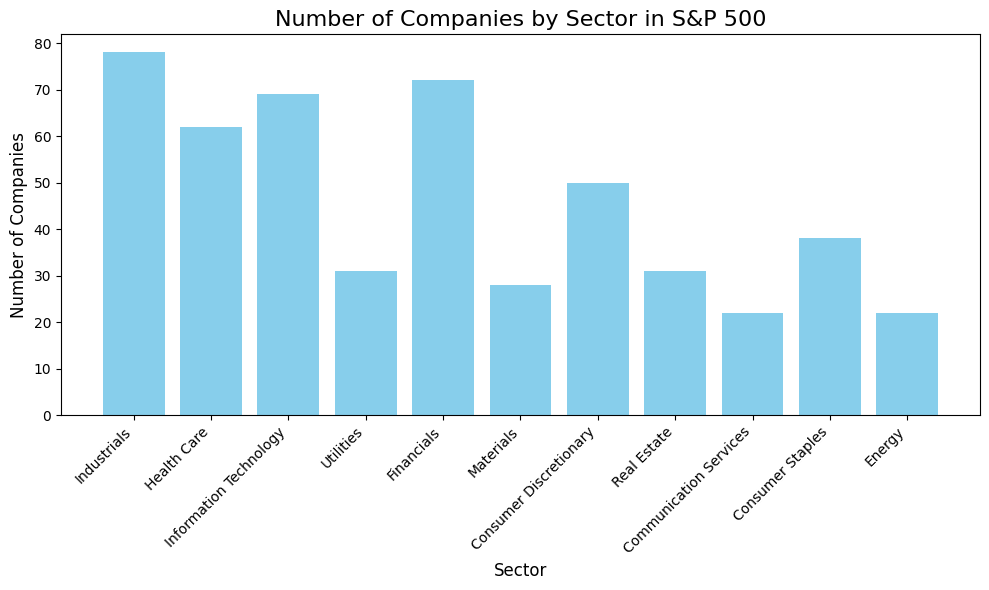

In [32]:
import matplotlib.pyplot as plt

for sector in SP500_company_data["GICS Sector"].unique():
    n_empresas = SP500_company_data[SP500_company_data["GICS Sector"] == sector]["GICS Sector"].count()
    print(f"Total de empresas no setor '{sector}' -> {n_empresas}")
    

sectors = SP500_company_data["GICS Sector"].unique()
counts = [SP500_company_data[SP500_company_data["GICS Sector"] == sector]["GICS Sector"].count() for sector in sectors]

plt.figure(figsize=(10, 6))
plt.bar(sectors, counts, color='skyblue')

plt.title("Number of Companies by Sector in S&P 500", fontsize=16)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Number of Companies", fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [33]:
def get_growth(df):
    # retorna o crescimento mensal da empresa 
    monthly_growth = 0
    monthly = df['close'].resample('ME').agg(['first', 'last'])
    
    for _, row in monthly.iterrows():
        monthly_growth += ((row['last'] - row['first']) / row['first']) * 100
        
    return monthly_growth/len(monthly)

In [15]:
growth = {}
sectors_growth = {}
for sector in SP500_company_data["GICS Sector"].unique():
    mean_growth_sector = 0
    sector_data = SP500_company_data[SP500_company_data["GICS Sector"] == sector]
    data = {}
    
    for company in sector_data["Symbol"]: 
        try:
            stock_growth = get_growth(SP500_train_data[SP500_train_data["ticker"]==company])
            mean_growth_sector += stock_growth
            data[company] = stock_growth
        except:
            ...
    growth[sector] = dict(sorted(data.items(), key=lambda item: item[1], reverse=True)) # ordenar por ordem decrescente
    sectors_growth[sector] = mean_growth_sector/len(data)
# ordenar em forma decrescente
sectors_growth = dict(sorted(sectors_growth.items(), key=lambda item: item[1], reverse=True))

### Identificar os melhores setores e respetivas melhores empresas

Identificamos quais os 5 melhores setores e as respetivas 30 melhores empresas

In [16]:
if not os.path.exists("dataset_by_sector/"):
    os.mkdir("dataset_by_sector/")
    
metadata = pd.DataFrame(columns=['ticker', 'sector', 'model'])
# metadata = metadata.append({'tinker': 'Tinker3', 'sector': 'Sector3', 'model': 'Model3'}, ignore_index=True)
j = 1
for sector,m_growth in sectors_growth.items():
    if j > 5: break
    i = 1
    print(f"{j}) Setor: {sector} (avg monthly growth: {m_growth:.4f}%) - all companies in sector")
    print("    < 30 best companies >")
    for company,data in growth[sector].items():
        if i > 30: break
        print(f"    {company} - avg monthly growth: {data:.4f}%")
        metadata.loc[len(metadata)] = [company,sector.replace(" ","_"),"por_definir"]
        # quando criarmos os modelos vamos associar a cada stock
        i += 1
    j += 1
metadata.to_csv(f"dataset_by_sector/metadata.csv")

1) Setor: Information Technology (avg monthly growth: 1.6906%) - all companies in sector
    < 30 best companies >
    PLTR - avg monthly growth: 4.8093%
    ENPH - avg monthly growth: 4.5056%
    NVDA - avg monthly growth: 4.3222%
    AMD - avg monthly growth: 3.2526%
    CRWD - avg monthly growth: 3.1527%
    ANET - avg monthly growth: 2.9773%
    AVGO - avg monthly growth: 2.8534%
    NOW - avg monthly growth: 2.7821%
    MPWR - avg monthly growth: 2.6723%
    PANW - avg monthly growth: 2.6632%
    SMCI - avg monthly growth: 2.6045%
    EPAM - avg monthly growth: 2.5880%
    FTNT - avg monthly growth: 2.4486%
    CDNS - avg monthly growth: 2.4176%
    LRCX - avg monthly growth: 2.3566%
    FICO - avg monthly growth: 2.3395%
    SNPS - avg monthly growth: 2.2480%
    ADBE - avg monthly growth: 2.1802%
    MU - avg monthly growth: 2.1777%
    AMAT - avg monthly growth: 2.0917%
    ZBRA - avg monthly growth: 2.0421%
    MSFT - avg monthly growth: 2.0040%
    KLAC - avg monthly growth: 

### Guardar os dados

Vamos agora guardar os dados das 30 melhores empresas por setor

In [17]:
if not os.path.exists("dataset_by_sector/train/"):
    os.mkdir("dataset_by_sector/train/")
    
if not os.path.exists("dataset_by_sector/test/"):
    os.mkdir("dataset_by_sector/test/")    

if not os.path.exists("dataset_by_sector/simulate/"):
    os.mkdir("dataset_by_sector/simulate/")    
    
limit_sector = 1

for sector,m_growth in sectors_growth.items():
    if limit_sector > 5: break
    limit_companies = 1
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_simulate = pd.DataFrame()
    
    for company,data in growth[sector].items():
        if limit_companies > 30: break

        df_train = pd.concat([df_train,SP500_train_data[SP500_train_data["ticker"]==company]])
        df_test = pd.concat([df_test,SP500_test_data[SP500_test_data["ticker"]==company]])
        df_simulate = pd.concat([df_simulate,SP500_simulate_data[SP500_simulate_data["ticker"]==company]])
        limit_companies += 1

    df_train.to_csv(f"dataset_by_sector/train/{sector.replace(' ','_')}.csv")
    df_test.to_csv(f"dataset_by_sector/test/{sector.replace(' ','_')}.csv")
    df_simulate.to_csv(f"dataset_by_sector/simulate/{sector.replace(' ','_')}.csv")
    limit_sector += 1


### Remover os datasets iniciais 

Remover os datasets que já não são necessários

In [34]:
del_files = ["companies_data.csv","stocks_train_data.csv","stocks_test_data.csv","stocks_simulate_data.csv"]

for csv_file in del_files:
    if os.path.exists(csv_file):
        os.remove(csv_file)
        print(f"Ficheiro '{csv_file}' removido com sucesso.")
    else:
        print(f"Ficheiro '{csv_file}' não encontrado.")

Ficheiro 'companies_data.csv' removido com sucesso.
Ficheiro 'stocks_train_data.csv' removido com sucesso.
Ficheiro 'stocks_test_data.csv' removido com sucesso.
Ficheiro 'stocks_simulate_data.csv' removido com sucesso.
